<a href="https://colab.research.google.com/github/wurDevTim/Workhshop_P4P/blob/main/introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welkom to the P4P workshop!
This notebook gives a few examples on how to analyse cropreporter data with plantcv. There are also various tutorials on the plantcv website, unfortunately they are not all updated to plantcv v4.0: https://plantcv.readthedocs.io/en/stable/tutorials/







# Preperation
For this training we prepared a small dataset you can use, please download it from:
https://drive.google.com/file/d/1qaFPIgGrOB_t1xNH8wub1LzzmV8uvSZG/view?usp=sharing

Unzip the folder and upload the content to your own  google drive.
Using the folder icon on the left side of the screen you can mount your own google drive to access the data from google colab

In [2]:
# Plantcv only suports python version 3.8, 3.9 and 3.10.
# Colab only supports one python version, the current version is 3.10.12
import sys
print(f"Running python version: {sys.version}")

Running python version: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


Install the requirements

In [3]:
# plantcv requires a newer version of altair than installed by default
!pip install altair==5.0.1
!pip install git+https://github.com/wurDevTim/plantcv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.5/471.5 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: altair
    Found existing installation: altair 4.2.2
    Uninstalling altair-4.2.2:
      Successfully uninstalled altair-4.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
  Cloning https://github.com/wurDevTim/plantcv to /tmp/pip-req-build-i7fvbkkv
  Running command git clone --filter=blob:none --quiet https://github.com/wurDevTim/plantcv /tmp/pip-req-build-i7fvbkkv
  Resolved https://github.com/wurDevTim/plantcv to commit 5fe40c7f6a11082663ab1201f573da891cc67362
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Check if the data folder is mounted correctly
datafolder = "/content/drive/My Drive/npec_tomato"
!ls $datafolder

ls: cannot access '/content/drive/My': No such file or directory
ls: cannot access 'Drive/npec_tomato': No such file or directory


In [13]:
# Importing Libraries
from google.colab.patches import cv2_imshow
# Import packages
from plantcv import plantcv as pcv
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Plantcv
Plantcv implements quite some functions, in the notebook examples are gives of how to load the data and:
- Use the Chlorophyll image to create a mask
- Compute the spectral indicies
- compute the FV/FM
- Analyse an entire folder automatically

For more information see:
https://plantcv.readthedocs.io/en/stable/photosynthesis_read_cropreporter/

In [6]:
# Configure plantcv to show debug output
pcv.params.debug = "plot"
pcv.params.debug_outdir = "temp_output"
outdir = 'temp_output'

Compiling: CHL
Compiling: CLR
Compiling: SPC


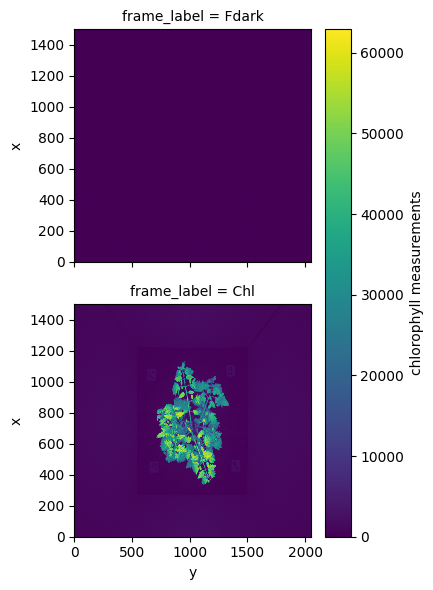

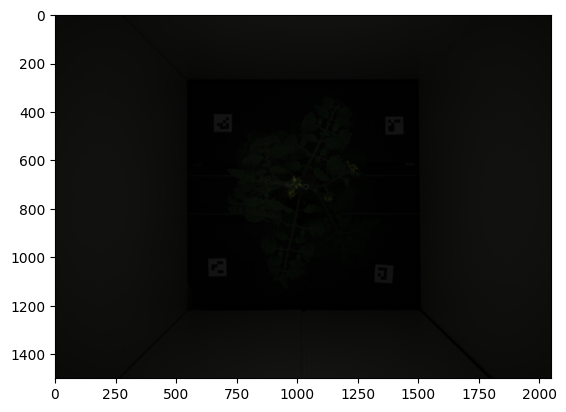

In [8]:
# Load the first dataset into plantcv
filename = datafolder + "/20231018_AO1/HDR_96_NPEC51.20230906.AO1.MoneyMaker.Salt.88_1476.INF"
ps = pcv.photosynthesis.read_cropreporter(filename=filename)

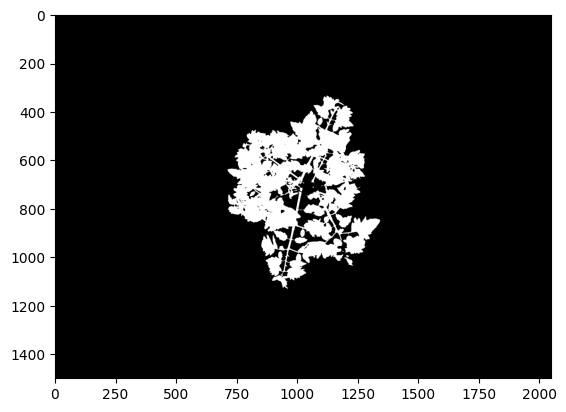

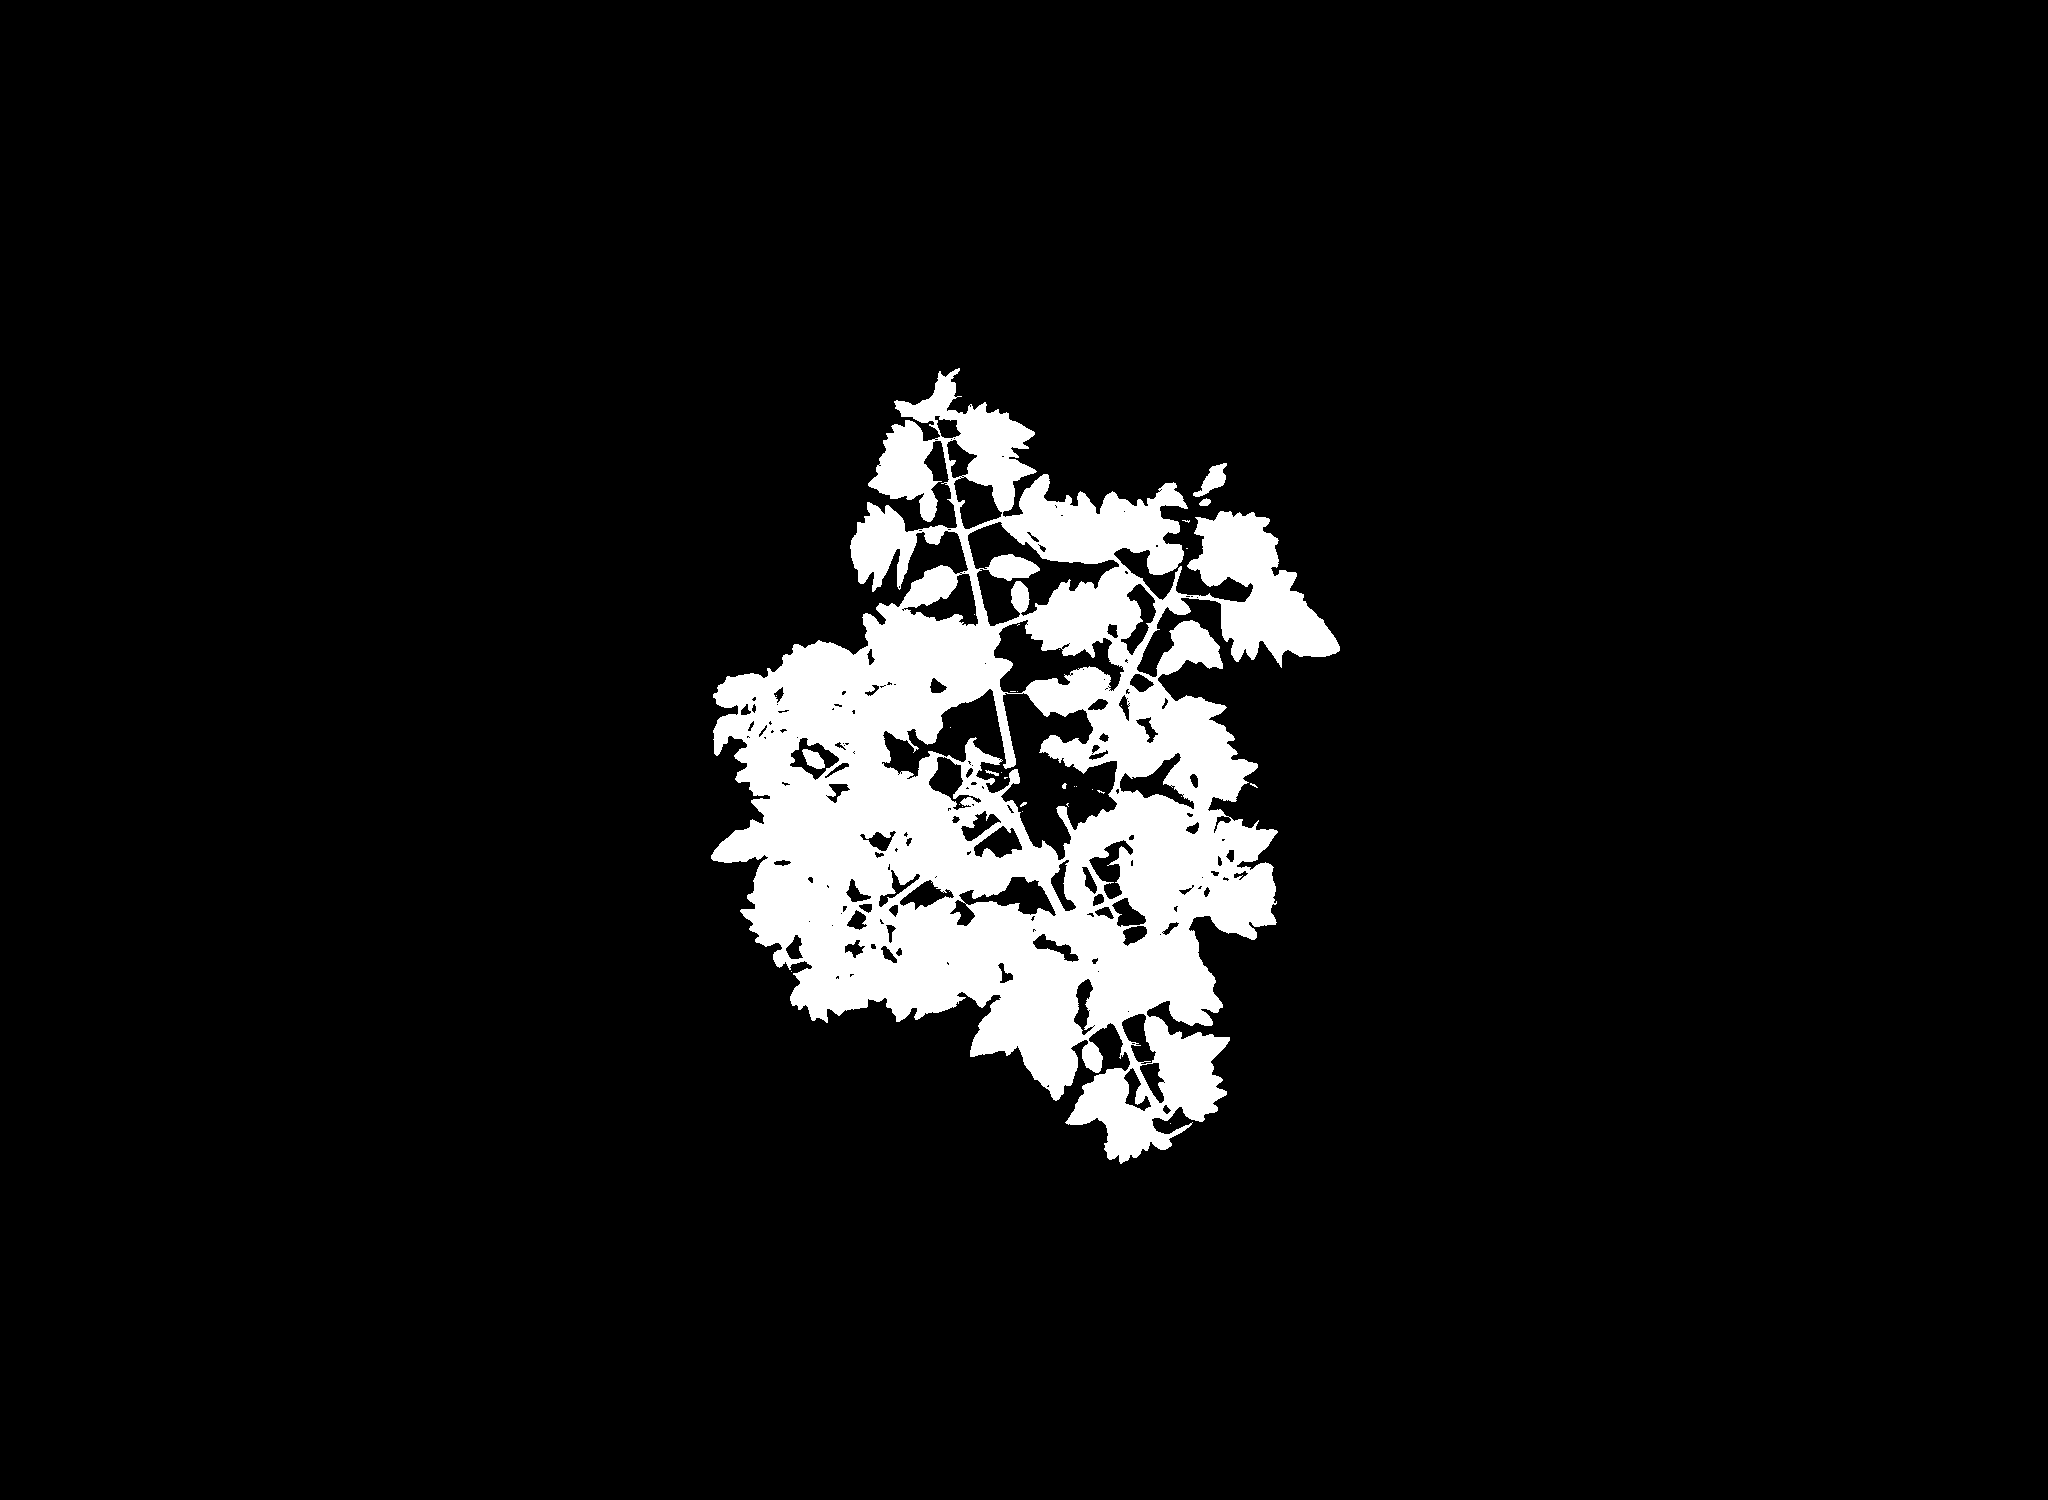

In [9]:
# Create a mask based on the Chlorophyll index
mask = pcv.threshold.otsu(gray_img=img_as_ubyte(ps.chlorophyll.sel(frame_label="Chl").data), object_type="light")
#mask = pcv.fill_holes(bin_img=mask)
mask = cv2.flip(mask, 0)
cv2_imshow(mask)

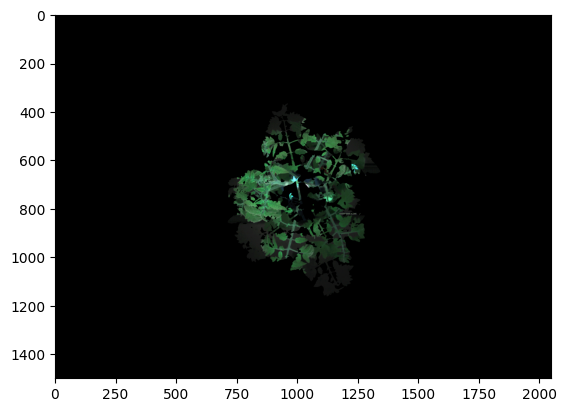

In [11]:
# Show the RGB image
img = ps.spectral.pseudo_rgb
img = cv2.bitwise_and(img, img, mask=mask)
# first parameter is the contract scaling, the second the brightness, which is increased slightly for vizualisation
# For a concrete example see: https://www.tutorialspoint.com/how-to-change-the-contrast-and-brightness-of-an-image-using-opencv-in-python
img = cv2.convertScaleAbs(img, 1.0, 10)
plt.imshow(img)

# Spectral indices

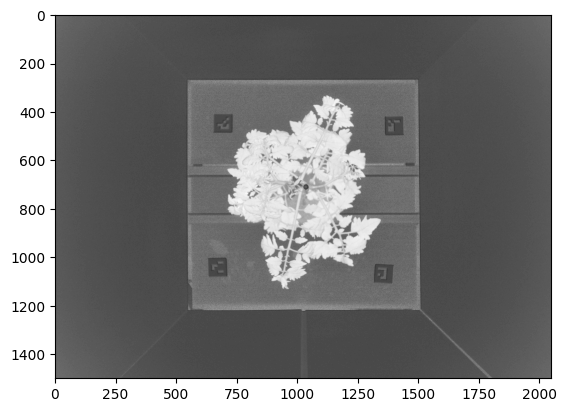

ndvi: 0.6172143816947937


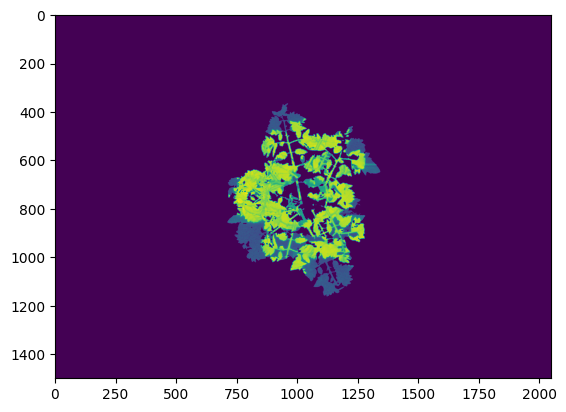

In [18]:
# Normalized Difference Vegetation Index: (R800 - R670) / (R800 + R670)
# The theoretical range for NDVI is [-1.0, 1.0]
ndvi_img = pcv.spectral_index.ndvi(hsi=ps.spectral).array_data
masked_ndvi_img = cv2.bitwise_and(ndvi_img, ndvi_img, mask=mask)
plt.imshow(masked_ndvi_img)
mean_ndvi = np.nanmean(ndvi_img[mask > 0])
print(f"ndvi: {mean_ndvi}")

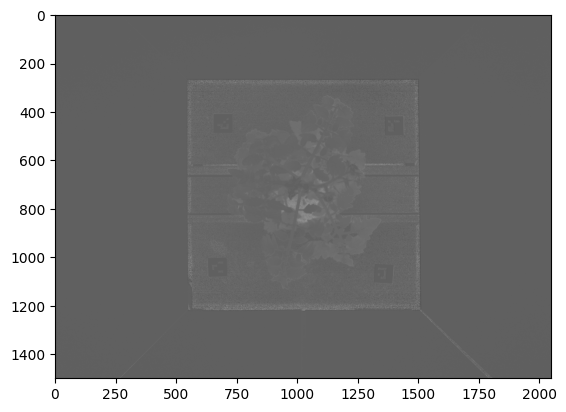

ari: 17.89004135131836


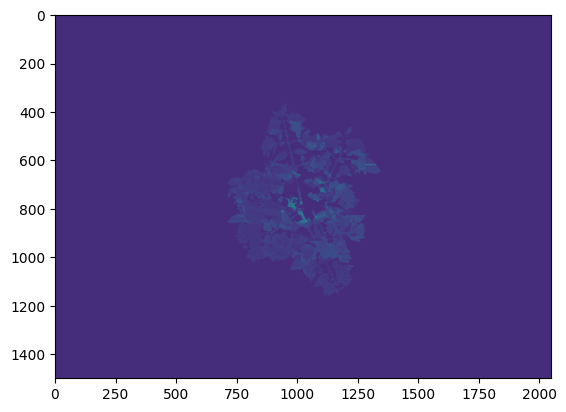

In [19]:
# Anthocyanin Reflectance Index: (1 / R550) - (1 / R700)
# The theoretical range for ARI is (-Inf, Inf)
ari_img = pcv.spectral_index.ari(hsi=ps.spectral).array_data
masked_ari_img = cv2.bitwise_and(ari_img, ari_img, mask=mask)
plt.imshow(masked_ari_img)
mean_ari = np.nanmean(ari_img[mask > 0])
print(f"ari: {mean_ari}")

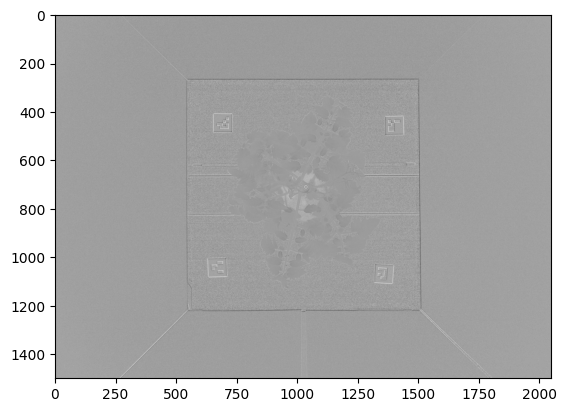

psri: -0.0514509454369545


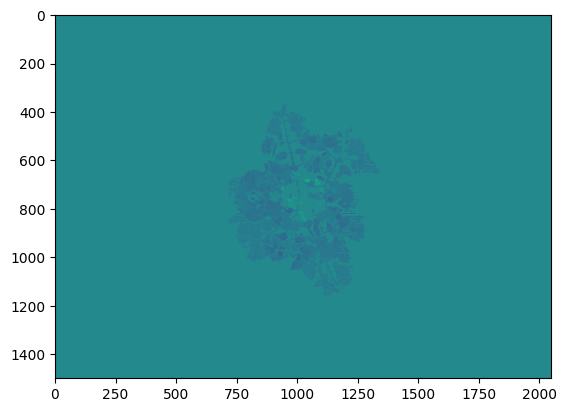

In [20]:
# Plant Senescence Reflectance Index: (R678 - R500) / R750
# The theoretical range for PSRI is (-Inf, Inf)
psri_img = pcv.spectral_index.psri(hsi=ps.spectral).array_data
masked_psri_img = cv2.bitwise_and(psri_img, psri_img, mask=mask)
plt.imshow(masked_psri_img)
mean_psri = np.nanmean(psri_img[mask > 0])
print(f"psri: {mean_psri}")

/usr/local/lib/python3.10/dist-packages/plantcv/plantcv/spectral_index/spectral_index.py:270: RuntimeWarning: invalid value encountered in divide
  r = red.astype(np.float32) / total
/usr/local/lib/python3.10/dist-packages/plantcv/plantcv/spectral_index/spectral_index.py:271: RuntimeWarning: invalid value encountered in divide
  g = green.astype(np.float32) / total
/usr/local/lib/python3.10/dist-packages/plantcv/plantcv/spectral_index/spectral_index.py:272: RuntimeWarning: invalid value encountered in divide
  b = blue.astype(np.float32) / total


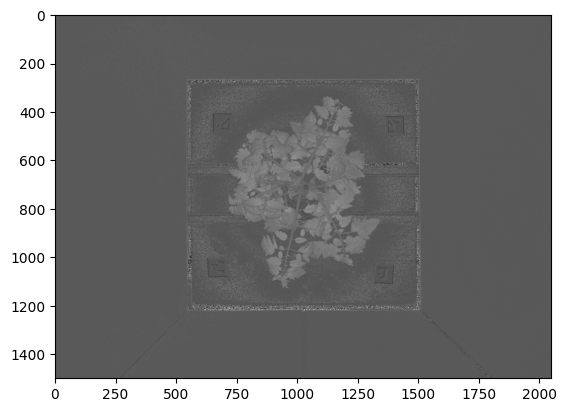

egreen: 0.2769092917442322


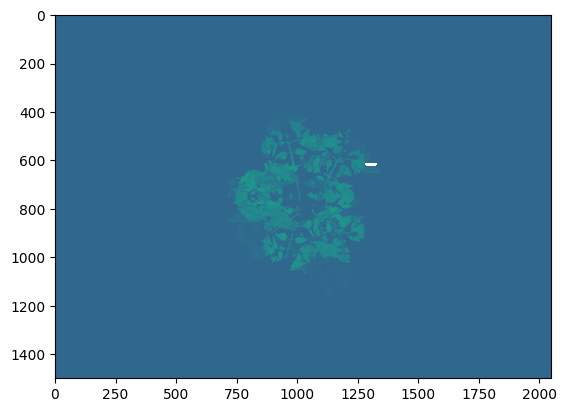

In [32]:
# Excess Green Index: 2g - r - b
# The theoretical range for EGI is (-1, 2)
# Question why do you see warnings?
egreen_img = pcv.spectral_index.egi(ps.spectral.pseudo_rgb).array_data
masked_egreen_img = cv2.bitwise_and(egreen_img, egreen_img, mask=mask)
plt.imshow(masked_egreen_img)
mean_egreen = np.nanmean(egreen_img[mask > 0])
print(f"egreen: {mean_egreen}")

#Photosynthesis analysis
FV/FM


In [ ]:
# Data quality check: How many pixels in the FM image are zero?
FM = None
if not ps.pam_dark is None:
  #Grab FM data
  FM = ps.pam_dark.sel(frame_label='Fm').to_numpy()
elif not ps.pam_light is None:
  #Grab FMp data
  FM = ps.pam_dark.sel(frame_label='Fmp').to_numpy()

if not FM is None:
  output = np.full(FM.shape, np.nan)
  output[mask > 0] = FM[mask > 0]
  output = output.flatten()
  print(f"{len(output[output == 0])} of the {len(output)} pixels, {int(len(output[output == 0])/len(output)*100)}% in the FM image are zero")

# Example to process a dataset
